In [ ]:
pip install pyarrow geoarrow-pyarrow geopandas earthaccess==0.9.0 jupyterlab_vim

In [1]:
import h5py
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import geoarrow.pyarrow as ga
from geoarrow.pyarrow import io
import geopandas as gpd
import numpy as np
import shapely
from datetime import datetime, timezone, timedelta

import json
import earthaccess
from earthaccess.results import DataGranule
from earthaccess.search import DataGranules
import fsspec
import os
import calendar

In [3]:
def result_bbox(result: DataGranule):
    points = result["umm"]["SpatialExtent"]["HorizontalSpatialDomain"]["Geometry"]["GPolygons"][0]["Boundary"]["Points"]

    longitudes = [point['Longitude'] for point in points]
    latitudes = [point['Latitude'] for point in points]

    min_lon, min_lat = min(longitudes), min(latitudes)
    max_lon, max_lat = max(longitudes), max(latitudes)
    bbox = shapely.geometry.box(min_lon, min_lat, max_lon, max_lat)
    return bbox

In [4]:
def results_bounds(results: list[DataGranule]):
    union_bbox = result_bbox(results[0])
    for result in results:
        bbox = result_bbox(result)  
        union_bbox = union_bbox.union(bbox)
    return list(union_bbox.envelope.bounds)

In [5]:
geo_metadata = {
    "columns": {
        "geometry": {
            "bbox": [
                -180.0,
                -90.0,
                180.0,
                83.6451
            ],
            "covering": {
                "bbox": {
                    "xmax": [
                        "bbox",
                        "xmax"
                    ],
                    "xmin": [
                        "bbox",
                        "xmin"
                    ],
                    "ymax": [
                        "bbox",
                        "ymax"
                    ],
                    "ymin": [
                        "bbox",
                        "ymin"
                    ]
                }
            },
            "crs": {
                "$schema": "https://proj.org/schemas/v0.6/projjson.schema.json",
                "area": "World.",
                "bbox": {
                    "east_longitude": 180,
                    "north_latitude": 90,
                    "south_latitude": -90,
                    "west_longitude": -180
                },
                "coordinate_system": {
                    "axis": [
                        {
                            "abbreviation": "Lon",
                            "direction": "east",
                            "name": "Geodetic longitude",
                            "unit": "degree"
                        },
                        {
                            "abbreviation": "Lat",
                            "direction": "north",
                            "name": "Geodetic latitude",
                            "unit": "degree"
                        }
                    ],
                    "subtype": "ellipsoidal"
                },
                "datum_ensemble": {
                    "accuracy": "2.0",
                    "ellipsoid": {
                        "inverse_flattening": 298.257223563,
                        "name": "WGS 84",
                        "semi_major_axis": 6378137
                    },
                    "id": {
                        "authority": "EPSG",
                        "code": 6326
                    },
                    "members": [
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1166
                            },
                            "name": "World Geodetic System 1984 (Transit)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1152
                            },
                            "name": "World Geodetic System 1984 (G730)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1153
                            },
                            "name": "World Geodetic System 1984 (G873)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1154
                            },
                            "name": "World Geodetic System 1984 (G1150)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1155
                            },
                            "name": "World Geodetic System 1984 (G1674)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1156
                            },
                            "name": "World Geodetic System 1984 (G1762)"
                        },
                        {
                            "id": {
                                "authority": "EPSG",
                                "code": 1309
                            },
                            "name": "World Geodetic System 1984 (G2139)"
                        }
                    ],
                    "name": "World Geodetic System 1984 ensemble"
                },
                "id": {
                    "authority": "OGC",
                    "code": "CRS84"
                },
                "name": "WGS 84 (CRS84)",
                "scope": "Not known.",
                "type": "GeographicCRS"
            },
            "edges": "planar",
            "encoding": "WKB",
            "geometry_types": [
                "Point",
            ]
        }
    },
    "primary_column": "geometry",
    "version": "1.1.0-dev"
}

In [6]:
def datasets_to_fields(group: h5py.Group):
    fields = []
    for key in group.keys():
        if isinstance(group[key], h5py.Dataset):
            dtype = group[key].dtype
            numpy_dtype = dtype.newbyteorder("=")
            arrow_type = pa.from_numpy_dtype(numpy_dtype)
            fields.append((key, arrow_type))
    return fields

In [7]:
def create_pyarrow_schema(template_file: h5py.File, geo_metadata: dict) -> pa.schema:
    land_segments_group = template_file["gt1l"]["land_segments"]
    canopy_group = template_file["gt1l"]["land_segments"]["canopy"]
    terrain_group = template_file["gt1l"]["land_segments"]["terrain"]  
    
    land_segment_fields = datasets_to_fields(land_segments_group)
    geometry_field = pa.field("geometry", pa.binary(), metadata={
        "encoding": "WKB",
        "geometry_types": "POINT"
    })
    land_segment_fields.append(geometry_field)
    beam_field = pa.field("beam", pa.string())
    land_segment_fields.append(beam_field) 
    canopy_fields = datasets_to_fields(canopy_group)
    terrain_fields = datasets_to_fields(terrain_group)



    fields = land_segment_fields + canopy_fields + terrain_fields

    metadata = json.dumps(geo_metadata).encode('utf-8')
    schema = pa.schema(fields, metadata={b"geo": metadata})
    
    return schema

In [8]:
def get_group_chunks(group: h5py.Group, offset: int, chunk_size: int) -> list[np.array]:
    chunks = []
    for key in group.keys():
        if isinstance(group[key], h5py.Dataset):
            if len(group[key].chunks) == 1:
                chunks.append(group[key][offset:offset+chunk_size])
            # Handle variables with land segment chunking
            elif len(group[key].chunks) == 2:
                chunks.append(group[key][offset:offset+chunk_size, 0])
    return chunks

In [9]:
def chunks_to_tables(result: DataGranule, fs, schema: pa.schema, beam: str):
    tables = []
    url = result.data_links(access="direct")[0]
    print(url)
    with fs.open(url, 'rb') as f:
        file = h5py.File(f)
        land_segments_group = file[beam]["land_segments"]
        canopy_group = file[beam]["land_segments"]["canopy"]
        terrain_group = file[beam]["land_segments"]["terrain"] 

        chunk_size = land_segments_group["latitude"].chunks[0]
        size = land_segments_group["latitude"].size
        number_of_chunks = (size // chunk_size) + 1
        
        for n in range(number_of_chunks):
            offset = n * chunk_size
            land_segment_chunks = get_group_chunks(land_segments_group, offset, chunk_size)
            # Populate geometry field
            geometries = []
            for lat, lon in zip(
                land_segments_group["latitude"][offset:offset+chunk_size],
                land_segments_group["longitude"][offset:offset+chunk_size]
            ):
                point = shapely.Point(lon, lat)
                point_wkb = shapely.to_wkb(point, flavor="iso")
                geometries.append(point_wkb)
            land_segment_chunks.append(geometries)
            # Append beam values
            beam_values = [beam] * len(geometries)
            land_segment_chunks.append(beam_values)

            canopy_chunks = get_group_chunks(canopy_group, offset, chunk_size)
            terrain_chunks = get_group_chunks(terrain_group, offset, chunk_size)
            chunks = land_segment_chunks + canopy_chunks + terrain_chunks
            table = pa.Table.from_arrays(chunks, schema=schema)   
            tables.append(table)
    return tables

In [10]:
def update_schema_geo_metadata(results: list[DataGranule], schema: pa.schema, geo_metadata: dict) -> pa.schema:
    bounds = results_bounds(results)
    metadata = schema.metadata.copy()
    geo_metadata["columns"]["geometry"]["bbox"] = bounds
    metadata[b"geo"] = json.dumps(geo_metadata).encode('utf-8')
    updated_schema = schema.with_metadata(metadata)
    return updated_schema

In [11]:
def write_results_by_group(results_list: list[DataGranule], num_files_per_group: int, fs, schema: pa.schema, geo_metadata: dict, file_name):
    results_schema = update_schema_geo_metadata(results_list, schema, geo_metadata)
    table_writer = pq.ParquetWriter(file_name, results_schema)
    for i in range(0, len(results_list), num_files_per_group):
        print(i)
        results_group = results_list[i:i+num_files_per_group]
        results_group_schema = update_schema_geo_metadata(results_group, schema, geo_metadata)
        beams = ["gt1l", "gt1r", "gt2l", "gt2r"]
        for beam in beams:
            results_group_tables = []
            for result in results_group:
                result_tables = chunks_to_tables(result, fs, results_group_schema, beam)
                results_group_tables.extend(result_tables)
        
            combined_table = pa.concat_tables(results_group_tables)
            table_writer.write_table(combined_table)
    table_writer.close()

In [6]:
start = datetime(2022, 10, 1, tzinfo=timezone.utc)
#next_month_days = calendar.monthrange(start.year, start.month + 1)[1]
end = start + timedelta(days=7)

results = earthaccess.search_data(
    short_name="ATL08",
    cloud_hosted=True,
    temporal=(start, end),
    count=-1
)
year_month = f"year={start.year}/month={start.month}"
week = 0
len(results)


Granules found: 1084


1084

In [7]:
results[10]["umm"]

{'RelatedUrls': [{'URL': 'https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001014058_01581701_006_01.h5',
   'Type': 'GET DATA',
   'MimeType': 'application/x-hdf5'},
  {'URL': 'https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001014058_01581701_006_01.h5.dmrpp',
   'Type': 'VIEW RELATED INFORMATION',
   'MimeType': 'application/vnd.opendap.dap4.dmrpp+xml'},
  {'URL': 'https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-public/ATLAS/ATL08/006/2022/10/01/ATL08_20221001014058_01581701_006_01.iso.xml',
   'Type': 'VIEW RELATED INFORMATION',
   'MimeType': 'text/xml'},
  {'URL': 'https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-public/ATLAS/ATL08/006/2022/10/01/ATL08_20221001014058_01581701_006_01_BRW.default.default1.jpg',
   'Type': 'GET RELATED VISUALIZATION',
   'MimeType': 'image/jpeg'},
  {'URL': 'https://data.nsidc.earthdatacloud.nasa.gov/n

In [13]:
sorted_results = sorted(results, key=lambda r : datetime.strptime(r['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'], '%Y-%m-%dT%H:%M:%S.%fZ'))

In [9]:
s3 = fsspec.filesystem('s3')

In [14]:
f = s3.open(results[10].data_links(access="direct")[0], 'rb')
file = h5py.File(f)
f.size / (1024 * 1024)

25.493762969970703

In [16]:
template_schema = create_pyarrow_schema(file, geo_metadata)

In [17]:
results_subset = sorted_results[0:30]

In [18]:
partition = f"atl08_parquet/{year_month}"
os.makedirs(partition, exist_ok=True)
file_name = f"{partition}/{week}.parquet"
write_results_by_group(results_subset, 10, s3, template_schema, geo_metadata, file_name)

0
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001000640_01571701_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001001342_01571702_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001002212_01571703_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001002737_01571704_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001003247_01571705_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001003812_01571706_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001004642_01571707_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001010648_01571710_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001011429_01571711_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2022/10/01/ATL08_20221001012012_0157171

In [ ]:
gdf = gpd.read_parquet('atl08_parquet')
gdf

In [75]:
gdf = gpd.read_parquet('atl08_parquet/year=2023/month=9/output.parquet_0')
gdf.total_bounds

array([-179.99505615,  -88.03861237,  179.99952698,   70.57292175])

In [2]:
file_size_bytes = os.path.getsize('atl08_parquet/year=2022/month=10/0.parquet')

# Convert bytes to megabytes
file_size_mb = file_size_bytes / (1024 * 1024)
file_size_mb

277.1439905166626

In [3]:
from shapely import wkb
dataset = pq.ParquetDataset("atl08_parquet", partitioning="hive", filters=[('year', '>=', 2022),
                                                     ('year', '<=', 2022),
                                                     ('month', '>=', 10),
                                                     ('month', '<=', 10)])
table = dataset.read(columns=["h_canopy", "geometry", "beam"])
df = table.to_pandas()
df['geometry'] = df['geometry'].apply(wkb.loads)


gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf

,h_canopy,geometry,beam
0,3.402823e+38,POINT (-85.91640 11.40717),gt1l
1,3.402823e+38,POINT (-85.91650 11.40807),gt1l
2,3.402823e+38,POINT (-85.91659 11.40898),gt1l
3,3.402823e+38,POINT (-85.91668 11.40988),gt1l
4,3.402823e+38,POINT (-85.91677 11.41078),gt1l
...,...,...,...
1120232,3.402823e+38,POINT (-162.11581 55.43220),gt2r
1120233,3.402823e+38,POINT (-162.11598 55.43310),gt2r
1120234,3.402823e+38,POINT (-162.11612 55.43399),gt2r
1120235,3.402823e+38,POINT (-162.11627 55.43489),gt2r


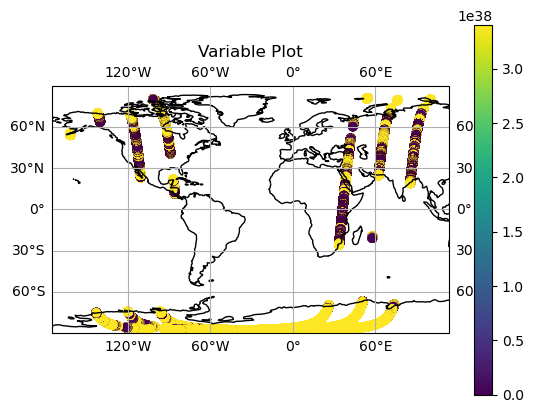

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs

crs = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
gdf.plot(column='h_canopy', ax=ax, legend=True, cmap='viridis')
ax.set_title('Variable Plot')

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)

# Show plot
plt.show()